In [133]:
#Importing necessary packages
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [134]:
# Picking up an equation for gradient evaluation
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [135]:
#Manual gradient evaluation
#Derivatives of d with respect to a, b and c
h = 0.0001

#Derivative of d with respect to a
a += h
d1 = a*b + c
agrad = (d1-d)/h
print(f'Derivative of d with respect to a - ', agrad)

#Derivative of d with respect to b
a -= h
b +=h
d2 = a*b + c
bgrad = (d2-d)/h
print(f'Derivative of d with respect to b - ', bgrad)

#Derivative of d with respect to c
b -= h
c +=h
d3 = a*b + c
cgrad = (d3-d)/h
print(f'Derivative of d with respect to c - ', cgrad)

Derivative of d with respect to a -  -3.000000000010772
Derivative of d with respect to b -  2.0000000000042206
Derivative of d with respect to c -  0.9999999999976694


In [136]:
#Basic building block of micrograd - Value Class (Mimics PyTorch)

class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self._backward =lambda: None
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f'Value(data={self.data})'
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out= Value(self.data + other.data,(self,other),'+')
        #defining gradient of output with respect to two inputs - self and other
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out= Value(self.data * other.data,(self,other),'*')
        #defining gradient of output with respect to two inputs - self and other
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad

        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
  
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def backward(self):
        topo=[]
        visited=set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()
  



In [137]:
#Helper function to printout the individual blocks
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
        
    nodes, edges = trace(root)
        
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad ), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label = n._op)
            dot.edge(uid + n._op,uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
            
    return dot

In [138]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0, label= 'c')
e = a*b; e.label= 'e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

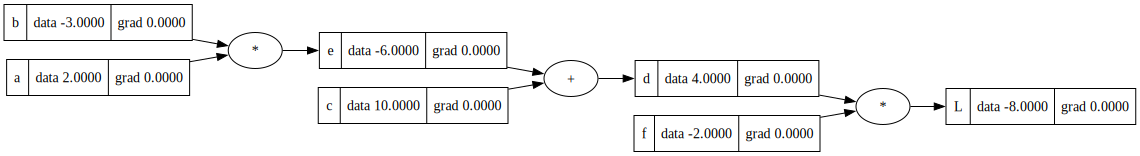

In [139]:
#pictorial representation of L
draw_dot(L)

In [140]:
#Deriving gradients

# Derivative of L with respect to L will always be 1.
L.grad = 1
#Calling backward function on L to calculate the derivative of L with respect to f and d.
L._backward()
#Calling backward function on d to calculate the derivative of L with respect to e and c
d._backward()
#Calling backward function on e to calculate the derivative of L with respect to a and b
e._backward()

In [141]:
#Now that we have derived gradient for all points. Lets try to tweak the output L. If I want to increase the value of L, then we just need to tweak all the inputs in the direction of gradient.

a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-7.286496


In [142]:
#Getting to the basic building block of neural network - neuron 
#Neuron basically contains three components -

# 1. List of inputs from the other neurons which are weighted by synapsis and picked up for processing.
# 2. Bias - Which basically adds a level of threshold for the activation for the neuron. Bias is actually the level at which the nueron gets activated when all its inputs are zero.
# 3. Activation function - A function that basically introduces non-linearity in the neural network. Without this function, neural network could be replaced with just one single linear transformation

# An Output from a neuron can be put as -
# Inputs x1 and x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

# Weights / Synapsis for inputs - w1 and w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

#Bias
b = Value(6.8813735870195432,label='b')

#Weighted inputs
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

#Sum of weighted inputs
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b;
o = n.tanh()


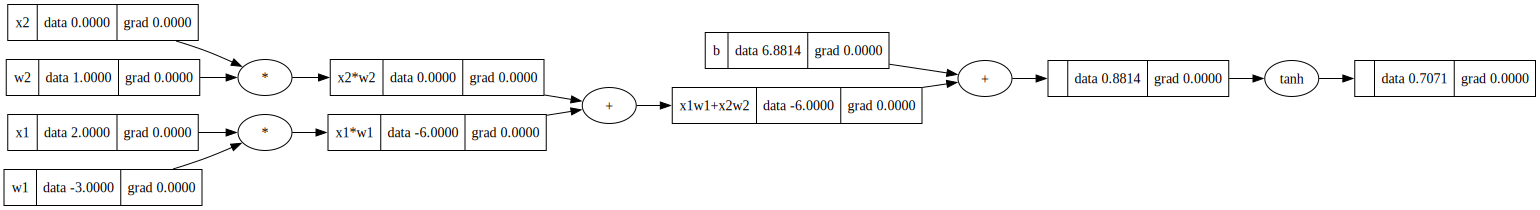

In [143]:
draw_dot(o)

In [144]:
o.backward()


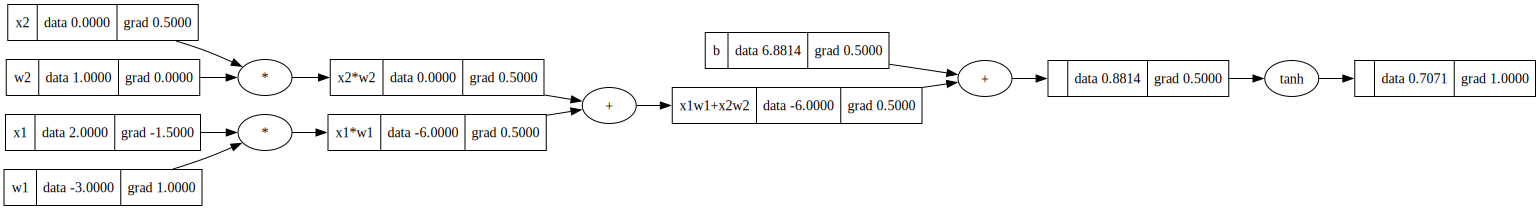

In [145]:
draw_dot(o)

In [146]:
import torch

In [147]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

0.7071066904050358


In [148]:
print('---Derivatives calculated ---')
print('x1 derivative',x1.grad.item())
print('x2 derivative',x2.grad.item())
print('w1 derivative',w1.grad.item())
print('w2 derivative',w2.grad.item())

---Derivatives calculated ---
x1 derivative -1.5000003851533106
x2 derivative 0.5000001283844369
w1 derivative 1.0000002567688737
w2 derivative 0.0


In [149]:
import random
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [150]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.88780637332676)

In [151]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [153]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  


0 0.02823573765476288
1 0.026438038927433412
2 0.024846013066943208
3 0.023426336703320748
4 0.022152601265233753
5 0.02100357671905566
6 0.019961983257605394
7 0.019013602569554346
8 0.018146622189513153
9 0.017351143529315403
10 0.016618807176249535
11 0.015942503699074715
12 0.015316147786934865
13 0.014734499957423909
14 0.014193024445939346
15 0.013687774929718378
16 0.013215301888381633
17 0.012772576943101379
18 0.012356930635749871
19 0.01196600093270222


In [154]:
ypred

[Value(data=0.9473091597952095),
 Value(data=-0.989681036229909),
 Value(data=-0.9251557940349884),
 Value(data=0.9409954229623335)]